In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


C:\Users\Surya\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
from sklearn.externals import joblib


## Train 

In [405]:
train = pd.read_csv('train_v2.csv')
train.shape

(970960, 2)

## Members

In [406]:
members = pd.read_csv('members_v3.csv')
members.shape

(6769473, 6)

In [407]:
# we are joining members and train dataframe based on msno 

a = pd.merge(train, members, on = 'msno', how = 'left')

In [ ]:
## mention reasons

In [408]:
# dropping the bd ,gender and all null columns

a = a.drop(['bd', 'gender'], axis = 1)
a = a.dropna(axis = 0, how = 'any')

# splitting the date to year,month and day

a['registration_init_time'] = pd.to_datetime(a['registration_init_time'], format = "%Y%m%d")
a['registration_init_time_year'] = a['registration_init_time'].apply(lambda date : date.year)
a['registration_init_time_month'] = a['registration_init_time'].apply(lambda date : date.month)
a['registration_init_time_day'] = a['registration_init_time'].apply(lambda date : date.day)

a = a.drop('registration_init_time', 1)
a.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25


## Transactions

In [409]:
# combining both the transaction data

transactions_1 = pd.read_csv('transactions.csv')
transactions = transactions_1.append(pd.read_csv('transactions_v2.csv'))

In [410]:
# https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

# grouping the data based on msno and performing aggregation to make it as a single record

grouped = transactions.copy().groupby('msno')
b = grouped.agg({'msno' :{'trans_count': 'count'},
                       'payment_plan_days' :{'transaction_span': 'sum'},
                       'plan_list_price' :{'total_list_price':'sum'},
                       'actual_amount_paid' : {'total_amount_paid' : 'sum'},
                       'is_auto_renew' :{'is_auto_renew': 'max'},
                       'is_cancel' : {'is_cancel_sum': 'sum'}})

b.columns = b.columns.droplevel(0)
b.reset_index(inplace = True)

# getting new features difference_in_price_paid and amount_paid_perday

b['difference_in_price_paid'] = b['total_list_price'] - b['total_amount_paid']
b['amount_paid_perday'] = b['total_amount_paid'] / b['transaction_span']
b.head()

,msno,trans_count,transaction_span,total_list_price,total_amount_paid,is_auto_renew,is_cancel_sum,difference_in_price_paid,amount_paid_perday
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1,7,0,0,0,0,0,0.000000
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2,805,3387,3387,0,0,0,4.207453
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,5,150,495,495,1,0,0,3.300000
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,21,603,2980,3129,1,0,-149,5.189055
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,27,780,3874,4023,1,0,-149,5.157692


In [411]:
# removing the duplicate records and is_auto_renew,membership_expire_date columns

c = transactions.sort_values('transaction_date', ascending = False).reset_index(drop = True)
c = c.drop_duplicates(subset = ['msno'], keep = 'first')
c = c.drop(['is_auto_renew', 'membership_expire_date'], 1)
c.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,transaction_date,is_cancel
0,nlwI4rVeDrFDFjkHBXuMBBXAWvhTv9miDiEGdaMDiXs=,41,30,99,99,20170331,0
1,GOKnXKY9XXaf3PaL9seD4HENmWw3o5WFUKTKL2irFrA=,39,30,149,149,20170331,0
2,TJ6nxPb8NDfeKb8HpZz2HemVvZHZdS52OJdMYFCZHv4=,41,30,99,99,20170331,0
3,9NwzFDrPGKgEuLKrM7EXsqg+VtebHhJ5WJFDOWhY4bQ=,41,30,99,99,20170331,0
4,TM/4vR23dnG79lZCqimPzRLBCq6RlG3ibOqs1Wd9IgY=,34,30,149,149,20170331,0


In [412]:
# merging the previous data frame into a single data frame

d = pd.merge(a, c, on = 'msno', how = 'left')
d = pd.merge(d, b, on = 'msno', how = 'left')
d.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date,is_cancel,trans_count,transaction_span,total_list_price,total_amount_paid,is_auto_renew,is_cancel_sum,difference_in_price_paid,amount_paid_perday
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23,38,30,149,...,20170228,0,6,60,298,894,1,1,-596,14.900000
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23,36,30,180,...,20170311,0,6,157,807,807,0,0,0,5.140127
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27,15,90,300,...,20170314,0,20,690,2982,2982,0,0,0,4.321739
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9,41,30,149,...,20160225,1,29,787,3874,4172,1,3,-298,5.301144
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25,41,30,99,...,20170316,0,32,870,3321,3748,1,3,-427,4.308046


In [413]:
# splitting the date to year,month and day

d['transaction_date'] = pd.to_datetime(d['transaction_date'], format = "%Y%m%d")
d['transaction_date_year'] = d['transaction_date'].apply(lambda date : date.year)
d['transaction_date_month'] = d['transaction_date'].apply(lambda date : date.month)
d['transaction_date_day'] = d['transaction_date'].apply(lambda date : date.day)

d = d.drop('transaction_date', 1)
d.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_span,total_list_price,total_amount_paid,is_auto_renew,is_cancel_sum,difference_in_price_paid,amount_paid_perday,transaction_date_year,transaction_date_month,transaction_date_day
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23,38,30,149,...,60,298,894,1,1,-596,14.900000,2017,2,28
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23,36,30,180,...,157,807,807,0,0,0,5.140127,2017,3,11
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27,15,90,300,...,690,2982,2982,0,0,0,4.321739,2017,3,14
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9,41,30,149,...,787,3874,4172,1,3,-298,5.301144,2016,2,25
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25,41,30,99,...,870,3321,3748,1,3,-427,4.308046,2017,3,16


## User logs

In [414]:
user_logs = pd.read_csv('user_logs_v2.csv')
user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [415]:
# grouping the data based on msno and performing aggregation to make it as a single record

grouped = user_logs.copy().groupby('msno')
e = grouped.agg({'msno' :{'logs_count': 'count'},
                  'num_25' : {'num_25' : 'sum'},
                  'num_50' : {'num_50' : 'sum'},
                  'num_75' : {'num_75' : 'sum'},
                  'num_985' : {'num_985' : 'sum'},
                  'num_100' : {'num_100' : 'sum'},
                  'num_unq' : {'num_unq' : 'sum'},
                  'total_secs' : {'total_secs' : 'sum'},
                       })

e.columns = e.columns.droplevel(0)
e.reset_index(inplace = True)
e.head()

,msno,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,26,86,11,10,5,472,530,117907.425
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,31,191,90,75,144,589,885,192527.892
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,28,43,12,15,12,485,468,115411.260
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,21,207,163,100,64,436,828,149896.558
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,29,105,24,39,35,479,230,116433.247


In [416]:
# final df

final = pd.merge(d, e, on = 'msno', how = 'left')
final.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date_month,transaction_date_day,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23,38,30,149,...,2,28,11.0,186.0,23.0,13.0,10.0,318.0,348.0,80598.557
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23,36,30,180,...,3,11,6.0,0.0,4.0,2.0,0.0,26.0,30.0,6986.509
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27,15,90,300,...,3,14,20.0,239.0,57.0,32.0,22.0,205.0,432.0,67810.467
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9,41,30,149,...,2,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25,41,30,99,...,3,16,15.0,9.0,7.0,4.0,4.0,962.0,548.0,239882.241


In [417]:
# dropping all null records

final = final.dropna(axis = 0, how = 'any')

In [418]:
final.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date_month,transaction_date_day,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23,38,30,149,...,2,28,11.0,186.0,23.0,13.0,10.0,318.0,348.0,80598.557
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23,36,30,180,...,3,11,6.0,0.0,4.0,2.0,0.0,26.0,30.0,6986.509
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27,15,90,300,...,3,14,20.0,239.0,57.0,32.0,22.0,205.0,432.0,67810.467
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25,41,30,99,...,3,16,15.0,9.0,7.0,4.0,4.0,962.0,548.0,239882.241
5,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,22.0,3.0,2014,1,26,40,30,149,...,3,16,4.0,6.0,1.0,1.0,4.0,37.0,48.0,10110.665


In [419]:
final.to_csv('final.csv',index=False) 

In [2]:
final=pd.read_csv('final.csv')

In [421]:
final.columns

Index(['msno', 'is_churn', 'city', 'registered_via',
       'registration_init_time_year', 'registration_init_time_month',
       'registration_init_time_day', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_cancel', 'trans_count',
       'transaction_span', 'total_list_price', 'total_amount_paid',
       'is_auto_renew', 'is_cancel_sum', 'difference_in_price_paid',
       'amount_paid_perday', 'transaction_date_year', 'transaction_date_month',
       'transaction_date_day', 'logs_count', 'num_25', 'num_50', 'num_75',
       'num_985', 'num_100', 'num_unq', 'total_secs'],
      dtype='object')

## Submission

In [ ]:
# test data is prepared on the same way and nulls are filled with 0

In [26]:
test=pd.read_csv('sample_submission_v2.csv')
test.shape

(907471, 2)

In [27]:
a = pd.merge(test, members, on = 'msno', how = 'left')
a = a.drop(['bd', 'gender'], axis = 1)

In [28]:
a['registration_init_time'] = pd.to_datetime(a['registration_init_time'], format = "%Y%m%d")
a['registration_init_time_year'] = a['registration_init_time'].apply(lambda date : date.year)
a['registration_init_time_month'] = a['registration_init_time'].apply(lambda date : date.month)
a['registration_init_time_day'] = a['registration_init_time'].apply(lambda date : date.day)

In [29]:
a = a.drop('registration_init_time', 1)
a.shape

(907471, 7)

In [30]:
d = pd.merge(a, c, on = 'msno', how = 'left')
d = pd.merge(d, b, on = 'msno', how = 'left')
d.shape

(907471, 21)

In [31]:
d['transaction_date'] = pd.to_datetime(d['transaction_date'], format = "%Y%m%d")
d['transaction_date_year'] = d['transaction_date'].apply(lambda date : date.year)
d['transaction_date_month'] = d['transaction_date'].apply(lambda date : date.month)
d['transaction_date_day'] = d['transaction_date'].apply(lambda date : date.day)

In [32]:
d = d.drop('transaction_date', 1)
d.shape

(907471, 23)

In [33]:
final_test = pd.merge(d, e, on = 'msno', how = 'left')
final_test.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date_day,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,secs_per_song
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,1.0,7.0,2015.0,7.0,18.0,41.0,30.0,99.0,...,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,4.0,9.0,2005.0,10.0,30.0,34.0,30.0,149.0,...,28.0,31.0,550.0,176.0,125.0,131.0,1701.0,2273.0,500802.64,186.657712
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,4.0,7.0,2014.0,11.0,1.0,41.0,30.0,99.0,...,15.0,10.0,79.0,19.0,1.0,2.0,84.0,149.0,23814.27,128.725784
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,NaN,NaN,NaN,NaN,NaN,41.0,30.0,99.0,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,1.0,13.0,2016.0,12.0,22.0,30.0,30.0,129.0,...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
final_test=final_test.fillna(0)

In [42]:
final_test.to_csv('final_test.csv',index=False) 

In [6]:
final_test=pd.read_csv('final_test.csv')

In [423]:
final_test.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date_month,transaction_date_day,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,1.0,7.0,2015.0,7.0,18.0,41,30,99,...,3,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,4.0,9.0,2005.0,10.0,30.0,34,30,149,...,3,31,31.0,550.0,176.0,125.0,131.0,1701.0,2273.0,500802.64
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,4.0,7.0,2014.0,11.0,1.0,41,30,99,...,3,15,10.0,79.0,19.0,1.0,2.0,84.0,149.0,23814.27
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,0.0,0.0,0.0,0.0,0.0,41,30,99,...,3,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,1.0,13.0,2016.0,12.0,22.0,30,30,129,...,3,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [155]:
final_test.columns

Index(['city', 'registered_via', 'registration_init_time_year',
       'registration_init_time_month', 'registration_init_time_day',
       'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_cancel', 'trans_count', 'transaction_span',
       'total_list_price', 'total_amount_paid', 'is_auto_renew',
       'is_cancel_sum', 'diff_in_price_paid', 'amt_per_day',
       'transaction_date_year', 'transaction_date_month',
       'transaction_date_day', 'logs_count', 'num_25', 'num_50', 'num_75',
       'num_985', 'num_100', 'num_unq', 'total_secs', 'secs_per_song'],
      dtype='object')

In [424]:
final_test.shape

(907471, 31)

In [425]:
final.shape

(754532, 31)

### Categorical Features :

    city

    registered_via  

    registration_init_time_year 

    registration_init_time_month  
    
    registration_init_time_day  

    payment_method_id      

    payment_plan_days  

    is_cancel        

    is_auto_renew   

    transaction_date_year 

    transaction_date_month

    transaction_date_day 
    
### Numerical features :
    plan_list_price                 
    
    actual_amount_paid              
    
    trans_count                     
    
    transaction_span                
    
    total_list_price                
    
    total_amount_paid               
    
    is_cancel_sum                   
    
    difference_in_price_paid
    
    amount_paid_perday
    
    logs_count                      
    
    num_25                          
    
    num_50                          
    
    num_75                          
    
    num_985                         
    
    num_100                         
    
    num_unq                         
    
    total_secs                      
    
    

## Test Train Split

In [3]:
Y_train = final['is_churn'].values
final.drop(['is_churn','msno'], axis=1, inplace=True)

In [4]:
X_train = final
X_train.head(1)

,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_cancel,...,transaction_date_month,transaction_date_day,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,5.0,3.0,2013,12,23,38,30,149,149,0,...,2,28,11.0,186.0,23.0,13.0,10.0,318.0,348.0,80598.557


In [7]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train)

In [8]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)


## One Hot Encoding for Categorical features

### city

In [18]:
my_counter = Counter()
for city in final['city'].values.astype("U"):
    my_counter.update(city.split())

In [19]:
city_cat_dict = dict(my_counter)
sorted_city_cat_dict = dict(sorted(city_cat_dict.items(), key=lambda kv: kv[1]))

In [20]:
vectorizer_city_cat = CountVectorizer(vocabulary=list(sorted_city_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_city_cat.fit(X_train['city'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

city_cat_one_hot_train = vectorizer_city_cat.fit_transform(X_train['city'].values.astype("U"))
city_cat_one_hot_test = vectorizer_city_cat.transform(X_test['city'].values.astype("U"))
city_cat_one_hot_cv = vectorizer_city_cat.transform(X_cv['city'].values.astype("U"))


print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",city_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",city_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",city_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_city_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 21)
Shape of Test data - one hot encoding  (150907, 21)
Shape of Cv data - one hot encoding  (120725, 21)
['19.0', '20.0', '16.0', '7.0', '3.0', '21.0', '17.0', '10.0', '8.0', '18.0', '11.0', '9.0', '12.0', '14.0', '6.0', '22.0', '15.0', '4.0', '5.0', '13.0', '1.0']


### registered_via 

In [21]:
my_counter = Counter()
for registered_via in final['registered_via'].values.astype("U"):
    my_counter.update(registered_via.split())

In [22]:
registered_via_cat_dict = dict(my_counter)
sorted_registered_via_cat_dict = dict(sorted(registered_via_cat_dict.items(), key=lambda kv: kv[1]))

In [23]:
vectorizer_registered_via_cat = CountVectorizer(vocabulary=list(sorted_registered_via_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_registered_via_cat.fit(X_train['registered_via'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

registered_via_cat_one_hot_train = vectorizer_registered_via_cat.fit_transform(X_train['registered_via'].values.astype("U"))
registered_via_cat_one_hot_test = vectorizer_registered_via_cat.transform(X_test['registered_via'].values.astype("U"))
registered_via_cat_one_hot_cv = vectorizer_registered_via_cat.transform(X_cv['registered_via'].values.astype("U"))

print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",registered_via_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",registered_via_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",registered_via_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_registered_via_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 5)
Shape of Test data - one hot encoding  (150907, 5)
Shape of Cv data - one hot encoding  (120725, 5)
['13.0', '4.0', '3.0', '9.0', '7.0']


### registration_init_time_year

In [24]:
my_counter = Counter()
for registration_init_time_year in final['registration_init_time_year'].values.astype("U"):
    my_counter.update(registration_init_time_year.split())

In [25]:
registration_init_time_year_cat_dict = dict(my_counter)
sorted_registration_init_time_year_cat_dict = dict(sorted(registration_init_time_year_cat_dict.items(), key=lambda kv: kv[1]))

In [26]:
vectorizer_registration_init_time_year_cat = CountVectorizer(vocabulary=list(sorted_registration_init_time_year_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_registration_init_time_year_cat.fit(X_train['registration_init_time_year'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

registration_init_time_year_cat_one_hot_train = vectorizer_registration_init_time_year_cat.fit_transform(X_train['registration_init_time_year'].values.astype("U"))
registration_init_time_year_cat_one_hot_test = vectorizer_registration_init_time_year_cat.transform(X_test['registration_init_time_year'].values.astype("U"))
registration_init_time_year_cat_one_hot_cv = vectorizer_registration_init_time_year_cat.transform(X_cv['registration_init_time_year'].values.astype("U"))

print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",registration_init_time_year_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",registration_init_time_year_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",registration_init_time_year_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_registration_init_time_year_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 14)
Shape of Test data - one hot encoding  (150907, 14)
Shape of Cv data - one hot encoding  (120725, 14)
['2004', '2005', '2009', '2008', '2006', '2007', '2017', '2010', '2011', '2012', '2014', '2013', '2015', '2016']


### registration_init_time_month

In [27]:
my_counter = Counter()
for registration_init_time_month in final['registration_init_time_month'].values.astype("U"):
    my_counter.update(registration_init_time_month.split())

In [28]:
registration_init_time_month_cat_dict = dict(my_counter)
sorted_registration_init_time_month_cat_dict = dict(sorted(registration_init_time_month_cat_dict.items(), key=lambda kv: kv[1]))

In [29]:
vectorizer_registration_init_time_month_cat = CountVectorizer(vocabulary=list(sorted_registration_init_time_month_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_registration_init_time_month_cat.fit(X_train['registration_init_time_month'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

registration_init_time_month_cat_one_hot_train = vectorizer_registration_init_time_month_cat.fit_transform(X_train['registration_init_time_month'].values.astype("U"))
registration_init_time_month_cat_one_hot_test = vectorizer_registration_init_time_month_cat.transform(X_test['registration_init_time_month'].values.astype("U"))
registration_init_time_month_cat_one_hot_cv = vectorizer_registration_init_time_month_cat.transform(X_cv['registration_init_time_month'].values.astype("U"))

print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",registration_init_time_month_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",registration_init_time_month_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",registration_init_time_month_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_registration_init_time_month_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 12)
Shape of Test data - one hot encoding  (150907, 12)
Shape of Cv data - one hot encoding  (120725, 12)
['4', '5', '6', '3', '9', '7', '8', '11', '10', '12', '2', '1']


### registration_init_time_day

In [30]:
my_counter = Counter()
for registration_init_time_day in final['registration_init_time_day'].values.astype("U"):
    my_counter.update(registration_init_time_day.split())

In [31]:
registration_init_time_day_cat_dict = dict(my_counter)
sorted_registration_init_time_day_cat_dict = dict(sorted(registration_init_time_day_cat_dict.items(), key=lambda kv: kv[1]))

In [32]:
vectorizer_registration_init_time_day_cat = CountVectorizer(vocabulary=list(sorted_registration_init_time_day_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_registration_init_time_day_cat.fit(X_train['registration_init_time_day'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

registration_init_time_day_cat_one_hot_train = vectorizer_registration_init_time_day_cat.fit_transform(X_train['registration_init_time_day'].values.astype("U"))
registration_init_time_day_cat_one_hot_test = vectorizer_registration_init_time_day_cat.transform(X_test['registration_init_time_day'].values.astype("U"))
registration_init_time_day_cat_one_hot_cv = vectorizer_registration_init_time_day_cat.transform(X_cv['registration_init_time_day'].values.astype("U"))

print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",registration_init_time_day_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",registration_init_time_day_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",registration_init_time_day_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_registration_init_time_day_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 31)
Shape of Test data - one hot encoding  (150907, 31)
Shape of Cv data - one hot encoding  (120725, 31)
['31', '2', '1', '30', '29', '13', '14', '3', '8', '27', '25', '24', '28', '22', '12', '15', '26', '7', '18', '11', '20', '5', '9', '21', '19', '4', '10', '23', '16', '17', '6']


### payment_method_id

In [33]:
my_counter = Counter()
for payment_method_id in final['payment_method_id'].values.astype("U"):
    my_counter.update(payment_method_id.split())

In [34]:
payment_method_id_dict = dict(my_counter)
sorted_payment_method_id_dict_cat_dict = dict(sorted(payment_method_id_dict.items(), key=lambda kv: kv[1]))

In [35]:
vectorizer_payment_method_id_cat = CountVectorizer(vocabulary=list(sorted_city_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_payment_method_id_cat.fit(X_train['payment_method_id'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

payment_method_id_cat_one_hot_train = vectorizer_payment_method_id_cat.fit_transform(X_train['payment_method_id'].values.astype("U"))
payment_method_id_cat_one_hot_test = vectorizer_payment_method_id_cat.transform(X_test['payment_method_id'].values.astype("U"))
payment_method_id_cat_one_hot_cv = vectorizer_payment_method_id_cat.transform(X_cv['payment_method_id'].values.astype("U"))

print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",payment_method_id_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",payment_method_id_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",payment_method_id_cat_one_hot_cv.shape)


print("="*100)

print(vectorizer_payment_method_id_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 21)
Shape of Test data - one hot encoding  (150907, 21)
Shape of Cv data - one hot encoding  (120725, 21)
['19.0', '20.0', '16.0', '7.0', '3.0', '21.0', '17.0', '10.0', '8.0', '18.0', '11.0', '9.0', '12.0', '14.0', '6.0', '22.0', '15.0', '4.0', '5.0', '13.0', '1.0']


### payment_plan_days

In [36]:
my_counter = Counter()
for payment_plan_days in final['payment_plan_days'].values.astype("U"):
    my_counter.update(payment_plan_days.split())

In [37]:
payment_plan_days_dict = dict(my_counter)
sorted_payment_plan_days_dict_cat_dict = dict(sorted(payment_plan_days_dict.items(), key=lambda kv: kv[1]))

In [38]:
vectorizer_payment_plan_days_cat = CountVectorizer(vocabulary=list(sorted_payment_plan_days_dict_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_payment_plan_days_cat.fit(X_train['payment_plan_days'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

payment_plan_days_cat_one_hot_train = vectorizer_payment_plan_days_cat.fit_transform(X_train['payment_plan_days'].values.astype("U"))
payment_plan_days_cat_one_hot_test = vectorizer_payment_plan_days_cat.transform(X_test['payment_plan_days'].values.astype("U"))
payment_plan_days_cat_one_hot_cv = vectorizer_payment_plan_days_cat.transform(X_cv['payment_plan_days'].values.astype("U"))

print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",payment_plan_days_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",payment_plan_days_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",payment_plan_days_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_payment_plan_days_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 27)
Shape of Test data - one hot encoding  (150907, 27)
Shape of Cv data - one hot encoding  (120725, 27)
['230', '35', '80', '415', '270', '70', '14', '110', '10', '1', '450', '240', '365', '400', '200', '45', '395', '60', '7', '120', '100', '360', '180', '90', '195', '410', '30']


### is_cancel

In [39]:
my_counter = Counter()
for is_cancel in final['is_cancel'].values.astype("U"):
    my_counter.update(is_cancel.split())

In [40]:
is_cancel_cat_dict = dict(my_counter)
sorted_is_cancel_cat_dict_cat_dict = dict(sorted(is_cancel_cat_dict.items(), key=lambda kv: kv[1]))

In [41]:
vectorizer_is_cancel_cat = CountVectorizer(vocabulary=list(sorted_is_cancel_cat_dict_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_is_cancel_cat.fit(X_train['is_cancel'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

is_cancel_cat_one_hot_train = vectorizer_is_cancel_cat.fit_transform(X_train['is_cancel'].values.astype("U"))
is_cancel_cat_one_hot_test = vectorizer_is_cancel_cat.transform(X_test['is_cancel'].values.astype("U"))
is_cancel_cat_one_hot_cv = vectorizer_is_cancel_cat.transform(X_cv['is_cancel'].values.astype("U"))

print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",is_cancel_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",is_cancel_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",is_cancel_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_is_cancel_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 2)
Shape of Test data - one hot encoding  (150907, 2)
Shape of Cv data - one hot encoding  (120725, 2)
['1', '0']


### is_auto_renew

In [42]:
my_counter = Counter()
for is_auto_renew in final['is_auto_renew'].values.astype("U"):
    my_counter.update(is_auto_renew.split())

In [43]:
is_auto_renew_cat_dict = dict(my_counter)
sorted_is_auto_renew_cat_dict = dict(sorted(is_auto_renew_cat_dict.items(), key=lambda kv: kv[1]))

In [44]:
vectorizer_is_auto_renew_cat = CountVectorizer(vocabulary=list(sorted_is_auto_renew_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_is_auto_renew_cat.fit(X_train['is_auto_renew'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)


print("="*100)

is_auto_renew_cat_one_hot_train = vectorizer_is_auto_renew_cat.fit_transform(X_train['is_auto_renew'].values.astype("U"))
is_auto_renew_cat_one_hot_test = vectorizer_is_auto_renew_cat.transform(X_test['is_auto_renew'].values.astype("U"))
is_auto_renew_cat_one_hot_cv = vectorizer_is_auto_renew_cat.transform(X_cv['is_auto_renew'].values.astype("U"))

print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",is_auto_renew_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",is_auto_renew_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",is_auto_renew_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_is_auto_renew_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 2)
Shape of Test data - one hot encoding  (150907, 2)
Shape of Cv data - one hot encoding  (120725, 2)
['0', '1']


### transaction_date_year

In [45]:
my_counter = Counter()
for transaction_date_year in final['transaction_date_year'].values.astype("U"):
    my_counter.update(transaction_date_year.split())

In [46]:
transaction_date_year_cat_dict = dict(my_counter)
sorted_transaction_date_year_cat_dict = dict(sorted(transaction_date_year_cat_dict.items(), key=lambda kv: kv[1]))

In [47]:
vectorizer_transaction_date_year_cat = CountVectorizer(vocabulary=list(sorted_transaction_date_year_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_transaction_date_year_cat.fit(X_train['transaction_date_year'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)


print("="*100)

transaction_date_year_cat_one_hot_train = vectorizer_transaction_date_year_cat.fit_transform(X_train['transaction_date_year'].values.astype("U"))
transaction_date_year_cat_one_hot_test = vectorizer_transaction_date_year_cat.transform(X_test['transaction_date_year'].values.astype("U"))
transaction_date_year_cat_one_hot_cv = vectorizer_transaction_date_year_cat.transform(X_cv['transaction_date_year'].values.astype("U"))

print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",transaction_date_year_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",transaction_date_year_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",transaction_date_year_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_transaction_date_year_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 3)
Shape of Test data - one hot encoding  (150907, 3)
Shape of Cv data - one hot encoding  (120725, 3)
['2015', '2016', '2017']


### transaction_date_month

In [48]:
my_counter = Counter()
for transaction_date_month in final['transaction_date_month'].values.astype("U"):
    my_counter.update(transaction_date_month.split())

In [49]:
transaction_date_month_cat_dict = dict(my_counter)
sorted_transaction_date_month_cat_dict = dict(sorted(transaction_date_month_cat_dict.items(), key=lambda kv: kv[1]))

In [50]:
vectorizer_transaction_date_month_cat = CountVectorizer(vocabulary=list(sorted_transaction_date_month_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_transaction_date_month_cat.fit(X_train['transaction_date_month'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)

print("="*100)

transaction_date_month_cat_one_hot_train = vectorizer_transaction_date_month_cat.fit_transform(X_train['transaction_date_month'].values.astype("U"))
transaction_date_month_cat_one_hot_test = vectorizer_transaction_date_month_cat.transform(X_test['transaction_date_month'].values.astype("U"))
transaction_date_month_cat_one_hot_cv = vectorizer_transaction_date_month_cat.transform(X_cv['transaction_date_month'].values.astype("U"))

print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",transaction_date_month_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",transaction_date_month_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",transaction_date_month_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_transaction_date_month_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 12)
Shape of Test data - one hot encoding  (150907, 12)
Shape of Cv data - one hot encoding  (120725, 12)
['6', '5', '4', '7', '10', '11', '8', '12', '9', '1', '2', '3']


### transaction_date_day

In [51]:
my_counter = Counter()
for transaction_date_day in final['transaction_date_day'].values.astype("U"):
    my_counter.update(transaction_date_day.split())

In [52]:
transaction_date_day_cat_dict = dict(my_counter)
sorted_transaction_date_day_cat_dict = dict(sorted(transaction_date_day_cat_dict.items(), key=lambda kv: kv[1]))

In [53]:
vectorizer_transaction_date_day_cat = CountVectorizer(vocabulary=list(sorted_transaction_date_day_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_transaction_date_day_cat.fit(X_train['transaction_date_day'].values.astype("U"))

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_cv.shape, Y_cv.shape)


print("="*100)

transaction_date_day_cat_one_hot_train = vectorizer_transaction_date_day_cat.fit_transform(X_train['transaction_date_day'].values.astype("U"))
transaction_date_day_cat_one_hot_test = vectorizer_transaction_date_day_cat.transform(X_test['transaction_date_day'].values.astype("U"))
transaction_date_day_cat_one_hot_cv = vectorizer_transaction_date_day_cat.transform(X_cv['transaction_date_day'].values.astype("U"))
print("After vectorizations")
print("="*100)

print("Shape of Train data - one hot encoding",transaction_date_day_cat_one_hot_train.shape)
print("Shape of Test data - one hot encoding ",transaction_date_day_cat_one_hot_test.shape)
print("Shape of Cv data - one hot encoding ",transaction_date_day_cat_one_hot_cv.shape)

print("="*100)

print(vectorizer_transaction_date_day_cat.get_feature_names())

(482900, 29) (482900,)
(150907, 29) (150907,)
(120725, 29) (120725,)
After vectorizations
Shape of Train data - one hot encoding (482900, 31)
Shape of Test data - one hot encoding  (150907, 31)
Shape of Cv data - one hot encoding  (120725, 31)
['30', '29', '28', '13', '2', '1', '3', '14', '7', '4', '8', '10', '23', '24', '12', '22', '26', '11', '17', '25', '18', '15', '21', '9', '19', '6', '27', '5', '20', '16', '31']


## Numerical Features

### plan_list_price

In [54]:
from sklearn.preprocessing import StandardScaler

In [55]:
sc = StandardScaler()


In [56]:
data_for_normalization_train = X_train['plan_list_price']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['plan_list_price']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['plan_list_price']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

plan_list_price_train = sc.fit_transform(data_for_normalization_train)
plan_list_price_test = sc.transform(data_for_normalization_test)
plan_list_price_cv = sc.transform(data_for_normalization_cv)

### actual_amount_paid

In [57]:
data_for_normalization_train = X_train['actual_amount_paid']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['actual_amount_paid']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['actual_amount_paid']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

actual_amount_paid_train = sc.fit_transform(data_for_normalization_train)
actual_amount_paid_test = sc.transform(data_for_normalization_test)
actual_amount_paid_cv = sc.transform(data_for_normalization_cv)

### trans_count

In [58]:
data_for_normalization_train = X_train['trans_count']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['trans_count']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['trans_count']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

trans_count_train = sc.fit_transform(data_for_normalization_train)
trans_count_test = sc.transform(data_for_normalization_test)
trans_count_cv = sc.transform(data_for_normalization_cv)

### transaction_span

In [59]:
data_for_normalization_train = X_train['transaction_span']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['transaction_span']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['transaction_span']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

transaction_span_train = sc.fit_transform(data_for_normalization_train)
transaction_span_test = sc.transform(data_for_normalization_test)
transaction_span_cv = sc.transform(data_for_normalization_cv)

### total_list_price

In [60]:
data_for_normalization_train = X_train['total_list_price']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['total_list_price']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['total_list_price']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

total_list_price_train = sc.fit_transform(data_for_normalization_train)
total_list_price_test = sc.transform(data_for_normalization_test)
total_list_price_cv = sc.transform(data_for_normalization_cv)

### total_amount_paid

In [61]:
data_for_normalization_train = X_train['total_amount_paid']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['total_amount_paid']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['total_amount_paid']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

total_amount_paid_train = sc.fit_transform(data_for_normalization_train)
total_amount_paid_test = sc.transform(data_for_normalization_test)
total_amount_paid_cv = sc.transform(data_for_normalization_cv)

### is_cancel_sum

In [62]:
data_for_normalization_train = X_train['is_cancel_sum']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['is_cancel_sum']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['is_cancel_sum']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

is_cancel_sum_train = sc.fit_transform(data_for_normalization_train)
is_cancel_sum_test = sc.transform(data_for_normalization_test)
is_cancel_sum_cv = sc.transform(data_for_normalization_cv)

### diff_in_price_paid

In [74]:
data_for_normalization_train = X_train['difference_in_price_paid']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['difference_in_price_paid']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['difference_in_price_paid']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

diff_in_price_paid_train = sc.fit_transform(data_for_normalization_train)
diff_in_price_paid_test = sc.transform(data_for_normalization_test)
diff_in_price_paid_cv = sc.transform(data_for_normalization_cv)

### amt_per_day

In [78]:
data_for_normalization_train = X_train['amount_paid_perday']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['amount_paid_perday']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['amount_paid_perday']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

amt_per_day_train = sc.fit_transform(data_for_normalization_train)
amt_per_day_test = sc.transform(data_for_normalization_test)
amt_per_day_cv = sc.transform(data_for_normalization_cv)

### logs_count

In [65]:
data_for_normalization_train = X_train['logs_count']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['logs_count']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['logs_count']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

logs_count_train = sc.fit_transform(data_for_normalization_train)
logs_count_test = sc.transform(data_for_normalization_test)
logs_count_cv = sc.transform(data_for_normalization_cv)

### num_25

In [66]:
data_for_normalization_train = X_train['num_25']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['num_25']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['num_25']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

num_25_train = sc.fit_transform(data_for_normalization_train)
num_25_test = sc.transform(data_for_normalization_test)
num_25_cv = sc.transform(data_for_normalization_cv)

### num_50

In [67]:
data_for_normalization_train = X_train['num_50']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['num_50']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['num_50']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

num_50_train = sc.fit_transform(data_for_normalization_train)
num_50_test = sc.transform(data_for_normalization_test)
num_50_cv = sc.transform(data_for_normalization_cv)

### num_75

In [68]:
data_for_normalization_train = X_train['num_75']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['num_75']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['num_75']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

num_75_train = sc.fit_transform(data_for_normalization_train)
num_75_test = sc.transform(data_for_normalization_test)
num_75_cv = sc.transform(data_for_normalization_cv)

### num_985

In [69]:
data_for_normalization_train = X_train['num_985']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['num_985']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['num_985']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

num_985_train = sc.fit_transform(data_for_normalization_train)
num_985_test = sc.transform(data_for_normalization_test)
num_985_cv = sc.transform(data_for_normalization_cv)

### num_100

In [70]:
data_for_normalization_train = X_train['num_100']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['num_100']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['num_100']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

num_100_train = sc.fit_transform(data_for_normalization_train)
num_100_test = sc.transform(data_for_normalization_test)
num_100_cv = sc.transform(data_for_normalization_cv)

### num_unq

In [71]:
data_for_normalization_train = X_train['num_unq']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['num_unq']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['num_unq']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

num_unq_train = sc.fit_transform(data_for_normalization_train)
num_unq_test = sc.transform(data_for_normalization_test)
num_unq_cv = sc.transform(data_for_normalization_cv)

### total_secs

In [72]:
data_for_normalization_train = X_train['total_secs']
data_for_normalization_train=data_for_normalization_train.values.reshape(-1,1)

data_for_normalization_test = X_test['total_secs']
data_for_normalization_test=data_for_normalization_test.values.reshape(-1,1)

data_for_normalization_cv = X_cv['total_secs']
data_for_normalization_cv=data_for_normalization_cv.values.reshape(-1,1)

total_secs_train = sc.fit_transform(data_for_normalization_train)
total_secs_test = sc.transform(data_for_normalization_test)
total_secs_cv = sc.transform(data_for_normalization_cv)

## Merging all the features

In [79]:
from scipy.sparse import hstack

X_train_merge = hstack((city_cat_one_hot_train,registered_via_cat_one_hot_train,registration_init_time_year_cat_one_hot_train,
                       registration_init_time_month_cat_one_hot_train,registration_init_time_day_cat_one_hot_train,
                       payment_method_id_cat_one_hot_train,payment_plan_days_cat_one_hot_train,is_cancel_cat_one_hot_train,
                       is_auto_renew_cat_one_hot_train,transaction_date_year_cat_one_hot_train,
                       transaction_date_month_cat_one_hot_train,transaction_date_day_cat_one_hot_train,
                       plan_list_price_train,actual_amount_paid_train,trans_count_train,transaction_span_train,
                       total_list_price_train,total_amount_paid_train,is_cancel_sum_train,diff_in_price_paid_train,
                       amt_per_day_train,logs_count_train,num_25_train,num_50_train,num_75_train,num_985_train,
                       num_100_train,num_unq_train,total_secs_train)).tocsr()

X_test_merge = hstack((city_cat_one_hot_test,registered_via_cat_one_hot_test,registration_init_time_year_cat_one_hot_test,
                      registration_init_time_month_cat_one_hot_test,registration_init_time_day_cat_one_hot_test,
                      payment_method_id_cat_one_hot_test,payment_plan_days_cat_one_hot_test,is_cancel_cat_one_hot_test,
                      is_auto_renew_cat_one_hot_test,transaction_date_year_cat_one_hot_test,
                      transaction_date_month_cat_one_hot_test,transaction_date_day_cat_one_hot_test,
                      plan_list_price_test,actual_amount_paid_test,trans_count_test,transaction_span_test,
                      total_list_price_test,total_amount_paid_test,is_cancel_sum_test,diff_in_price_paid_test,
                      amt_per_day_test,logs_count_test,num_25_test,num_50_test,num_75_test,num_985_test,
                      num_100_test,num_unq_test,total_secs_test)).tocsr()

X_cv_merge = hstack((city_cat_one_hot_cv,registered_via_cat_one_hot_cv,registration_init_time_year_cat_one_hot_cv,
                      registration_init_time_month_cat_one_hot_cv,registration_init_time_day_cat_one_hot_cv,
                      payment_method_id_cat_one_hot_cv,payment_plan_days_cat_one_hot_cv,is_cancel_cat_one_hot_cv,
                      is_auto_renew_cat_one_hot_cv,transaction_date_year_cat_one_hot_cv,
                      transaction_date_month_cat_one_hot_cv,transaction_date_day_cat_one_hot_cv,
                      plan_list_price_cv,actual_amount_paid_cv,trans_count_cv,transaction_span_cv,
                      total_list_price_cv,total_amount_paid_cv,is_cancel_sum_cv,diff_in_price_paid_cv,
                      amt_per_day_cv,logs_count_cv,num_25_cv,num_50_cv,num_75_cv,num_985_cv,
                      num_100_cv,num_unq_cv,total_secs_cv)).tocsr()

## ML Models

In [80]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import log_loss
from datetime import datetime

In [84]:
def misclassified_points(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
   

## Random model

In [85]:
test_data_len = X_test_merge.shape[0]
cv_data_len = X_cv_merge.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,2))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,2)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(Y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,2))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,2)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(Y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
misclassified_points(Y_test, predicted_y+1)

Log loss on Cross Validation Data using Random Model 0.8843798790866191
Log loss on Test Data using Random Model 0.886895760566191
Number of misclassified points  95.55686614935026


### Logistic Regression with l2 penalty (with class balance)

for alpha = 1e-07
Log Loss : 0.20705939189388692
for alpha = 1e-06
Log Loss : 0.2013977027770745
for alpha = 1e-05
Log Loss : 0.19525944282218677
for alpha = 0.0001
Log Loss : 0.19668499530263045
for alpha = 0.001
Log Loss : 0.1999286577343005
for alpha = 0.01
Log Loss : 0.20623024226655895
for alpha = 0.1
Log Loss : 0.2108546410339655
for alpha = 1
Log Loss : 0.2169415264151701
for alpha = 10
Log Loss : 0.2200078371133053
for alpha = 100
Log Loss : 0.22038330868428987
for alpha = 1000
Log Loss : 0.22043171889546198


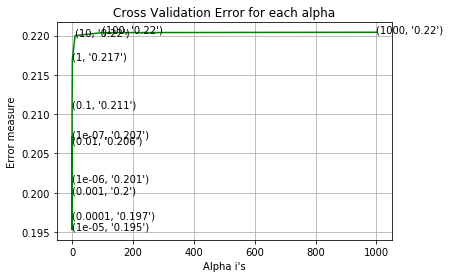

For values of best alpha =  1e-05 The train log loss is: 0.21968502918946137
For values of best alpha =  1e-05 The cross validation log loss is: 0.2200078371133053
For values of best alpha =  1e-05 The test log loss is: 0.2205487235366889
Number of misclassified points  6.3191236987018495


In [87]:
alpha = [10**x for x in range(-7, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight='balanced')
    clf.fit(X_train_merge, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_merge, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(X_train_merge, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_merge, Y_train)

predict_y = sig_clf.predict_proba(X_train_merge)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
misclassified_points(Y_test, sig_clf.predict(X_test_merge))

### Logistic Regression with l1 penalty (with class balance)

for alpha = 1e-07
Log Loss : 0.27197598847234206
for alpha = 1e-06
Log Loss : 0.26315066597815573
for alpha = 1e-05
Log Loss : 0.2394194993903096
for alpha = 0.0001
Log Loss : 0.2156289100409345
for alpha = 0.001
Log Loss : 0.20336071029222963
for alpha = 0.01
Log Loss : 0.2111665836080776
for alpha = 0.1
Log Loss : 0.23166156678750946
for alpha = 1
Log Loss : 0.30168897255186927
for alpha = 10
Log Loss : 0.3016889725518692
for alpha = 100
Log Loss : 0.30168897255186944
for alpha = 1000
Log Loss : 0.30168897255186944


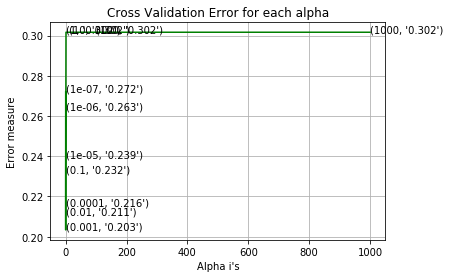

For values of best alpha =  0.001 The train log loss is: 0.3016841720881732
For values of best alpha =  0.001 The cross validation log loss is: 0.3016889725518692
For values of best alpha =  0.001 The test log loss is: 0.3016840995278699
Number of misclassified points  8.96313623622496


In [88]:
alpha = [10**x for x in range(-7, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42,class_weight='balanced')
    clf.fit(X_train_merge, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_merge, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42,class_weight='balanced')
clf.fit(X_train_merge, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_merge, Y_train)

predict_y = sig_clf.predict_proba(X_train_merge)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
misclassified_points(Y_test, sig_clf.predict(X_test_merge))

### Logistic Regression with l2 penalty (without class balance)

for alpha = 1e-07
Log Loss : 0.2105082175694251
for alpha = 1e-06
Log Loss : 0.19620424417742433
for alpha = 1e-05
Log Loss : 0.19649982020168968
for alpha = 0.0001
Log Loss : 0.19659166623220548
for alpha = 0.001
Log Loss : 0.19847672289624615
for alpha = 0.01
Log Loss : 0.20331280766391385
for alpha = 0.1
Log Loss : 0.2064340233857327
for alpha = 1
Log Loss : 0.21157849076999277
for alpha = 10
Log Loss : 0.21347334729978149
for alpha = 100
Log Loss : 0.2137292094344189
for alpha = 1000
Log Loss : 0.21375553694346036


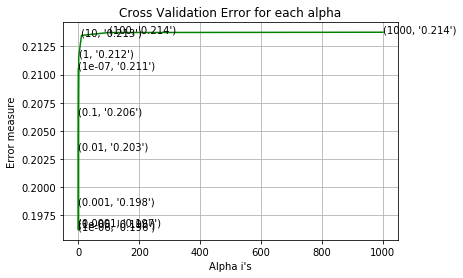

For values of best alpha =  1e-06 The train log loss is: 0.21332534750859208
For values of best alpha =  1e-06 The cross validation log loss is: 0.21347334729978149
For values of best alpha =  1e-06 The test log loss is: 0.2140415286287361
Number of misclassified points  6.0500838264626555


In [89]:
alpha = [10**x for x in range(-7, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_merge, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_merge, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
clf.fit(X_train_merge, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_merge, Y_train)

predict_y = sig_clf.predict_proba(X_train_merge)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
misclassified_points(Y_test, sig_clf.predict(X_test_merge))

### Logistic Regression with l1 penalty (without class balance)

for alpha = 1e-07
Log Loss : 0.2379382460911227
for alpha = 1e-06
Log Loss : 0.21124736656343274
for alpha = 1e-05
Log Loss : 0.195112149796236
for alpha = 0.0001
Log Loss : 0.19642570675191026
for alpha = 0.001
Log Loss : 0.19993730730539436
for alpha = 0.01
Log Loss : 0.2071696137205371
for alpha = 0.1
Log Loss : 0.22584673387275692
for alpha = 1
Log Loss : 0.3016889725518693
for alpha = 10
Log Loss : 0.30168897255186927
for alpha = 100
Log Loss : 0.3016889725518692
for alpha = 1000
Log Loss : 0.30168897255186944


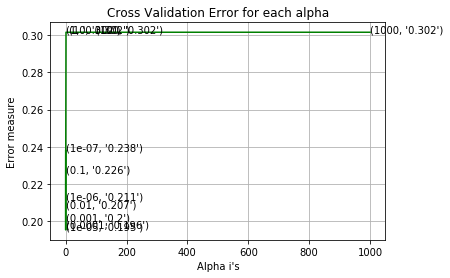

For values of best alpha =  1e-05 The train log loss is: 0.30168417208817333
For values of best alpha =  1e-05 The cross validation log loss is: 0.30168897255186927
For values of best alpha =  1e-05 The test log loss is: 0.30168409952787006
Number of misclassified points  8.96313623622496


In [90]:
alpha = [10**x for x in range(-7, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42)
    clf.fit(X_train_merge, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_merge, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42)
clf.fit(X_train_merge, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_merge, Y_train)

predict_y = sig_clf.predict_proba(X_train_merge)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
misclassified_points(Y_test, sig_clf.predict(X_test_merge))

### SVM with l2 penalty (with class balance)

for alpha = 1e-07
Log Loss : 0.20884500666909317
for alpha = 1e-06
Log Loss : 0.2011878067926459
for alpha = 1e-05
Log Loss : 0.1982557928619149
for alpha = 0.0001
Log Loss : 0.19923402025362444
for alpha = 0.001
Log Loss : 0.20197016917971375
for alpha = 0.01
Log Loss : 0.20732989787366998
for alpha = 0.1
Log Loss : 0.21368641719782594
for alpha = 1
Log Loss : 0.22792626653754441
for alpha = 10
Log Loss : 0.22006548481442936
for alpha = 100
Log Loss : 0.22043580466041177
for alpha = 1000
Log Loss : 0.2204358050323445


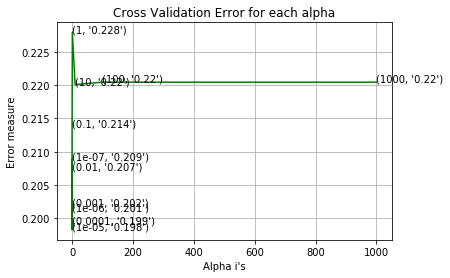

For values of best alpha =  1e-05 The train log loss is: 0.2198512903408357
For values of best alpha =  1e-05 The cross validation log loss is: 0.22006548481442936
For values of best alpha =  1e-05 The test log loss is: 0.22079300108797295
Number of misclassified points  6.330388915027135


In [91]:
alpha = [10**x for x in range(-7, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
    clf.fit(X_train_merge, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_merge, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
clf.fit(X_train_merge, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_merge, Y_train)

predict_y = sig_clf.predict_proba(X_train_merge)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
misclassified_points(Y_test, sig_clf.predict(X_test_merge))

### SVM with l1 penalty (with class balance)

for alpha = 1e-07
Log Loss : 0.25641081788576336
for alpha = 1e-06
Log Loss : 0.2638853760251815
for alpha = 1e-05
Log Loss : 0.24017002936638202
for alpha = 0.0001
Log Loss : 0.21717318909634176
for alpha = 0.001
Log Loss : 0.20750185656466022
for alpha = 0.01
Log Loss : 0.21046539566628655
for alpha = 0.1
Log Loss : 0.23325667482131876
for alpha = 1
Log Loss : 0.3016889725518692
for alpha = 10
Log Loss : 0.3016889725518693
for alpha = 100
Log Loss : 0.3016889725518692
for alpha = 1000
Log Loss : 0.3016889725518692


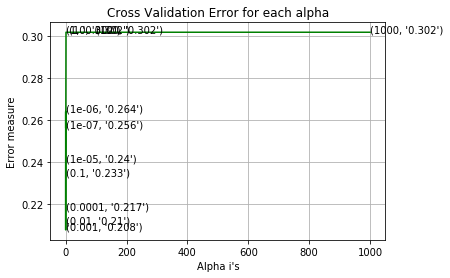

For values of best alpha =  0.001 The train log loss is: 0.3016841720881734
For values of best alpha =  0.001 The cross validation log loss is: 0.3016889725518693
For values of best alpha =  0.001 The test log loss is: 0.3016840995278701
Number of misclassified points  8.96313623622496


In [92]:
alpha = [10**x for x in range(-7, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
    clf.fit(X_train_merge, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_merge, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
clf.fit(X_train_merge, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_merge, Y_train)

predict_y = sig_clf.predict_proba(X_train_merge)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
misclassified_points(Y_test, sig_clf.predict(X_test_merge))

### SVM with l2 penalty (without class balance)

for alpha = 1e-07
Log Loss : 0.20858422690527365
for alpha = 1e-06
Log Loss : 0.21011461403592696
for alpha = 1e-05
Log Loss : 0.21477596769412338
for alpha = 0.0001
Log Loss : 0.22172711751358803
for alpha = 0.001
Log Loss : 0.2248027409631247
for alpha = 0.01
Log Loss : 0.2270514875820985
for alpha = 0.1
Log Loss : 0.22897129854894058
for alpha = 1
Log Loss : 0.22466307537327387
for alpha = 10
Log Loss : 0.21375823444601
for alpha = 100
Log Loss : 0.2137582242388131
for alpha = 1000
Log Loss : 0.21375822263478822


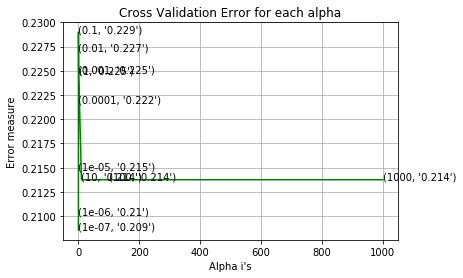

For values of best alpha =  1e-07 The train log loss is: 0.2136020778863768
For values of best alpha =  1e-07 The cross validation log loss is: 0.21375823444601
For values of best alpha =  1e-07 The test log loss is: 0.2143279877806894
Number of misclassified points  6.050746486246497


In [93]:
alpha = [10**x for x in range(-7, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_merge, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_merge, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_merge, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_merge, Y_train)

predict_y = sig_clf.predict_proba(X_train_merge)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
misclassified_points(Y_test, sig_clf.predict(X_test_merge))

### SVM with l1 penalty (without class balance)

for alpha = 1e-07
Log Loss : 0.2568548084115286
for alpha = 1e-06
Log Loss : 0.23550670575858831
for alpha = 1e-05
Log Loss : 0.21854778485284154
for alpha = 0.0001
Log Loss : 0.22198526705927396
for alpha = 0.001
Log Loss : 0.22586481938224684
for alpha = 0.01
Log Loss : 0.22491457228395254
for alpha = 0.1
Log Loss : 0.22384725556666293
for alpha = 1
Log Loss : 0.30168897255186944
for alpha = 10
Log Loss : 0.30168897255186927
for alpha = 100
Log Loss : 0.3016889725518694
for alpha = 1000
Log Loss : 0.3016889725518692


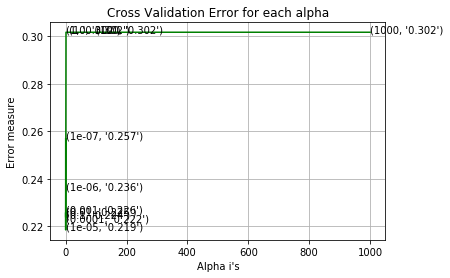

For values of best alpha =  1e-05 The train log loss is: 0.30168417208817333
For values of best alpha =  1e-05 The cross validation log loss is: 0.30168897255186927
For values of best alpha =  1e-05 The test log loss is: 0.30168409952787
Number of misclassified points  8.96313623622496


In [94]:
alpha = [10**x for x in range(-7, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_merge, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_merge, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_merge, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_merge, Y_train)

predict_y = sig_clf.predict_proba(X_train_merge)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
misclassified_points(Y_test, sig_clf.predict(X_test_merge))

### Light GBM with Class Balance

In [95]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [96]:
x_cfl=LGBMClassifier(objective = 'binary', eval_metric = 'logloss',class_weight='balanced')

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2,0.001,0.005,0.0001,0.0005],
     'n_estimators':[100,200,500,1000,2000,3500,5000,7000],
     'max_depth':[3,5,7,10,15,25,50,70,85,100],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1],
    'num_leaves ':[31,51,71,100,200,500,750,1000,1500,2000,2500,3000,3500,4000],
    'feature_fraction': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,return_train_score=True,scoring = "neg_log_loss",n_jobs=-1,
                             cv=5)
random_cfl.fit(X_train_merge,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 72.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 84.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 91.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 99.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight='balanced',
                                            colsample_bytree=1.0,
                                            eval_metric='logloss',
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective='binary',
                                            random_state=None, r...
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                             

In [98]:
print (random_cfl.best_params_)

{'subsample': 0.3, 'num_leaves ': 1500, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.2, 'feature_fraction': 0.2, 'colsample_bytree': 0.5}


In [99]:
x_cfl=LGBMClassifier(objective ='binary', eval_metric = 'logloss',class_weight='balanced',subsample=0.3,num_leaves =1500,
                    n_estimators=1000,max_depth=5,learning_rate=0.2,colsample_bytree=0.5,feature_fraction=0.2)
x_cfl.fit(X_train_merge,Y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_merge,Y_train)

CalibratedClassifierCV(base_estimator=LGBMClassifier(boosting_type='gbdt',
                                                     class_weight='balanced',
                                                     colsample_bytree=0.5,
                                                     eval_metric='logloss',
                                                     feature_fraction=0.2,
                                                     importance_type='split',
                                                     learning_rate=0.2,
                                                     max_depth=5,
                                                     min_child_samples=20,
                                                     min_child_weight=0.001,
                                                     min_split_gain=0.0,
                                                     n_estimators=1000,
                                                     n_jobs=-1, num_leaves=1500,
                           

In [100]:
predict_y = c_cfl.predict_proba(X_train_merge)
print ('train loss',log_loss(Y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv_merge)
print ('cv loss',log_loss(Y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test_merge)
print ('test loss',log_loss(Y_test, predict_y))

train loss 0.13059710340514294
cv loss 0.16021901509061195
test loss 0.161853181247459


### Light GBM without Class Balance

In [101]:
x_cfl=LGBMClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2,0.001,0.005,0.0001,0.0005],
     'n_estimators':[100,200,500,1000,2000,3500,5000,7000],
     'max_depth':[3,5,7,10,15,25,50,70,85,100],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1],
    'num_leaves ':[31,51,71,100,200,500,750,1000,1500,2000,2500,3000,3500,4000],
    'feature_fraction': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,return_train_score=True,scoring = "neg_log_loss",n_jobs=-1,
                             cv=5)
random_cfl.fit(X_train_merge,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 112.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 160.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 198.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 213.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                            

In [102]:
print (random_cfl.best_params_)

{'subsample': 0.3, 'num_leaves ': 31, 'n_estimators': 1000, 'max_depth': 70, 'learning_rate': 0.03, 'feature_fraction': 0.7, 'colsample_bytree': 0.1}


In [103]:
x_cfl=LGBMClassifier(subsample=0.3,num_leaves =31,n_estimators=1000,max_depth=70,learning_rate=0.03,
                     colsample_bytree=0.1,feature_fraction=0.7)
x_cfl.fit(X_train_merge,Y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_merge,Y_train)

CalibratedClassifierCV(base_estimator=LGBMClassifier(boosting_type='gbdt',
                                                     class_weight=None,
                                                     colsample_bytree=0.1,
                                                     feature_fraction=0.7,
                                                     importance_type='split',
                                                     learning_rate=0.03,
                                                     max_depth=70,
                                                     min_child_samples=20,
                                                     min_child_weight=0.001,
                                                     min_split_gain=0.0,
                                                     n_estimators=1000,
                                                     n_jobs=-1, num_leaves=31,
                                                     objective=None,
                                        

In [104]:
predict_y = c_cfl.predict_proba(X_train_merge)
print ('train loss',log_loss(Y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv_merge)
print ('cv loss',log_loss(Y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test_merge)
print ('test loss',log_loss(Y_test, predict_y))

train loss 0.15358697139957098
cv loss 0.16284991124008388
test loss 0.16586360715384366


In [110]:
x_cfl=LGBMClassifier(objective = 'binary', eval_metric = 'logloss',class_weight='balanced')

prams={
    'boosting_type':['gbdt','rf','dart','goss'],
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2,0.001,0.005,0.0001,0.0005],
     'n_estimators':[100,200,500,1000,2000,3500,5000,7000],
     'max_depth':[3,5,7,10,15,25,50,70,85,100],
    'colsample_bytree':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'num_leaves ':[31,51,71,100,200,500,750,1000,1500,2000,2500,3000,3500,4000],
    'feature_fraction': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    'random_state ':[42],
    'min_child_samples':[10,20,40,80,160,320],
    'min_child_weight':[0.1,0.01,0.001,0.0001,0.00001,0.000001]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,return_train_score=True,scoring = "neg_log_loss",n_jobs=-1,
                             cv=5)
random_cfl.fit(X_train_merge,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 49.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 113.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 224.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 224.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 279.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight='balanced',
                                            colsample_bytree=1.0,
                                            eval_metric='logloss',
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective='binary',
                                            random_state=None, r...
                                        'min_child_weight': [0.1, 0.01, 0.001,
                                               

In [111]:
print (random_cfl.best_params_)

{'subsample': 0.6, 'random_state ': 42, 'num_leaves ': 2000, 'n_estimators': 2000, 'min_child_weight': 1e-06, 'min_child_samples': 320, 'max_depth': 85, 'learning_rate': 0.2, 'feature_fraction': 0.6, 'colsample_bytree': 0.7, 'boosting_type': 'gbdt'}


In [113]:
x_cfl=LGBMClassifier(objective ='binary', eval_metric = 'logloss',class_weight='balanced',subsample=0.6,
                     random_state =42,num_leaves =2000,min_child_weight=1e-06,min_child_samples=320,boosting_type='gbdt',
                    n_estimators=2000,max_depth=85,learning_rate=0.2,colsample_bytree=0.7,feature_fraction=0.6)
x_cfl.fit(X_train_merge,Y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_merge,Y_train)

CalibratedClassifierCV(base_estimator=LGBMClassifier(boosting_type='gbdt',
                                                     class_weight='balanced',
                                                     colsample_bytree=0.7,
                                                     eval_metric='logloss',
                                                     feature_fraction=0.6,
                                                     importance_type='split',
                                                     learning_rate=0.2,
                                                     max_depth=85,
                                                     min_child_samples=320,
                                                     min_child_weight=1e-06,
                                                     min_split_gain=0.0,
                                                     n_estimators=2000,
                                                     n_jobs=-1, num_leaves=2000,
                         

In [114]:
predict_y = c_cfl.predict_proba(X_train_merge)
print ('train loss',log_loss(Y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv_merge)
print ('cv loss',log_loss(Y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test_merge)
print ('test loss',log_loss(Y_test, predict_y))

train loss 0.06450546297020252
cv loss 0.1842045397364159
test loss 0.18719478882188345


### Summary

In [73]:
from prettytable import PrettyTable

x = PrettyTable(["Model","Train log loss","Test log loss"])

x.add_row(["Logistic Regression with l2 penalty (with class balance) ","0.22286641206524002","0.09880498155077859"])
x.add_row(["Logistic Regression with l1 penalty (with class balance)","0.30168492564884297","0.09391116600747505"])
x.add_row(["Logistic Regression with l2 penalty (without class balance)","0.20845082735825843","0.13441988284221684"])
x.add_row(["Logistic Regression with l1 penalty (without class balance)","0.30168492564884436","0.09391116600746319"])
x.add_row(["SVM with l2 penalty (with class balance)","0.22274221022915308","0.09761945480396333"])
x.add_row(["SVM with l1 penalty (with class balance)","0.3016849256488436","0.09391116600747441"])
x.add_row(["SVM with l2 penalty (without class balance)","0.2109374368763923","0.13070482919331325"])
x.add_row(["SVM with l1 penalty (without class balance)","0.30168492564884447","0.09391116600742398"])
x.add_row(["Light GBM with Class Balance","0.07755079716933437","0.12857999767632128"])
x.add_row(["Light GBM without Class Balance","0.09796563076029288","0.18481715444520885"])

print(x)

+-------------------------------------------------------------+---------------------+---------------------+
|                            Model                            |    Train log loss   |    Test log loss    |
+-------------------------------------------------------------+---------------------+---------------------+
|  Logistic Regression with l2 penalty (with class balance)   | 0.22286641206524002 | 0.09880498155077859 |
|   Logistic Regression with l1 penalty (with class balance)  | 0.30168492564884297 | 0.09391116600747505 |
| Logistic Regression with l2 penalty (without class balance) | 0.20845082735825843 | 0.13441988284221684 |
| Logistic Regression with l1 penalty (without class balance) | 0.30168492564884436 | 0.09391116600746319 |
|           SVM with l2 penalty (with class balance)          | 0.22274221022915308 | 0.09761945480396333 |
|           SVM with l1 penalty (with class balance)          |  0.3016849256488436 | 0.09391116600747441 |
|         SVM with l2 penalt

SVM with l1 penalty (without class balance) gives the best test log loss but there is quite difference train and test loss.

Light GBM with class balance gives closer train and test loss, Light gbm withclass balance is the best model .